In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math

These housing prices are for houses Seattle, Washington USA. I used more variables than the assignment asked for, but I'm hoping that's okay.

C:\Users\bretw\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


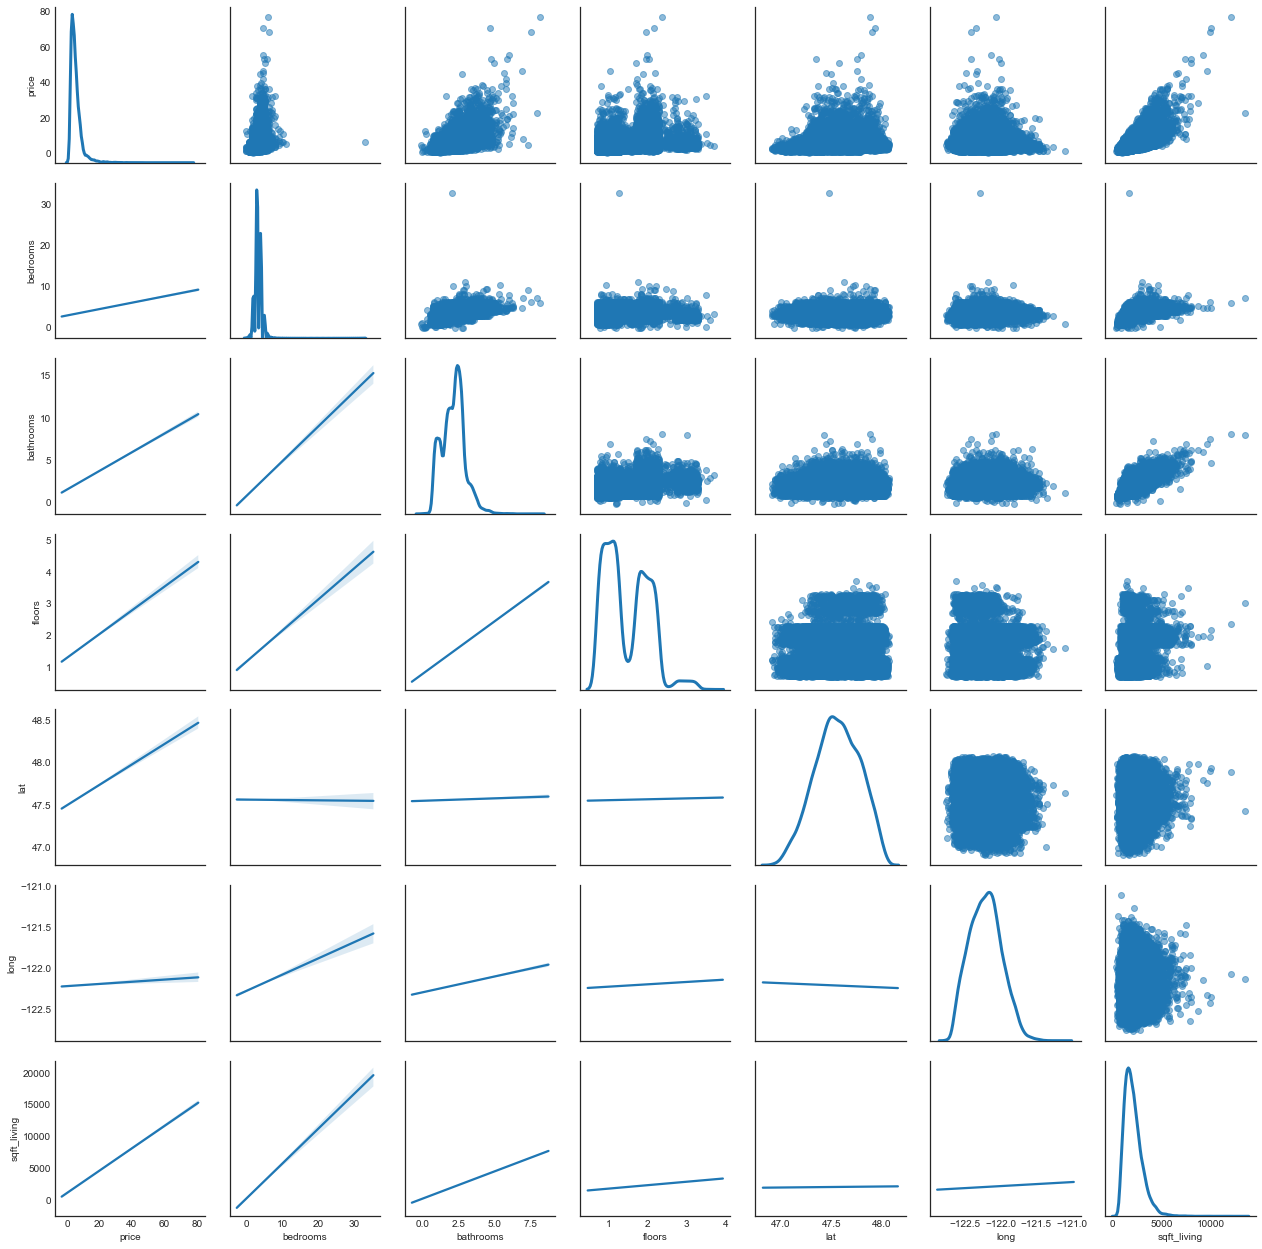

In [2]:
df = pd.read_csv('home_data.csv')

# Reduce the original data as per assignment requirements to 1 outcome (price),
# and 5 variables (2 categorical: bedrooms, floors).
df_explore = df.loc[:, ['waterfront', 'price', 'bedrooms','bathrooms', 'floors', 'lat', 'long', 'sqft_living']]
df_explore.price = df_explore.price.div(100000)

# I don't know which plot styles are nicest, so I'll use one from the course notes
sns.set_style('white')

# We will add jitter to all variables, then do a PairGrid.
df_jittered = df_explore.loc[:, 'price':'sqft_living'].dropna()
# Adding random noise.
jitter = pd.DataFrame(
np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)
# Combine the data and the noise.
df_jittered = df_jittered.add(jitter)

# Here is where we declare we are making a scatter plot matrix.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit a line showing linear relationship between varaibles.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give info about the univariate distribution of each variable.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

                price  bedrooms  bathrooms    floors       lat      long  \
price        1.000000  0.308350   0.525138  0.256794  0.307003  0.021626   
bedrooms     0.308350  1.000000   0.515884  0.175429 -0.008931  0.129473   
bathrooms    0.525138  0.515884   1.000000  0.500653  0.024573  0.223042   
floors       0.256794  0.175429   0.500653  1.000000  0.049614  0.125419   
lat          0.307003 -0.008931   0.024573  0.049614  1.000000 -0.135512   
long         0.021626  0.129473   0.223042  0.125419 -0.135512  1.000000   
sqft_living  0.702035  0.576671   0.754665  0.353949  0.052529  0.240223   

             sqft_living  
price           0.702035  
bedrooms        0.576671  
bathrooms       0.754665  
floors          0.353949  
lat             0.052529  
long            0.240223  
sqft_living     1.000000  


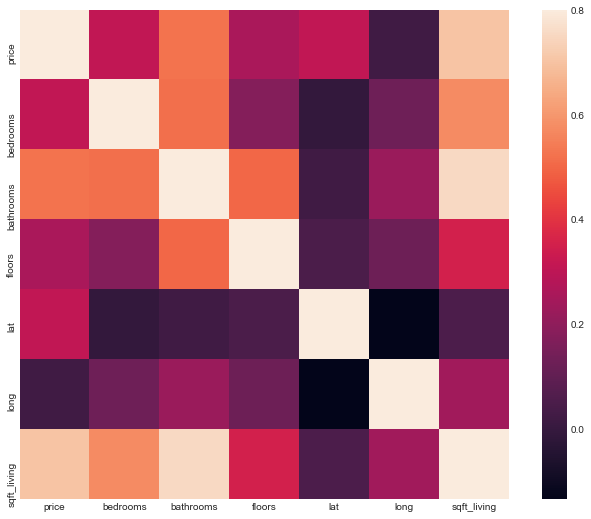

In [3]:
# Next, we'll make a correlation matrix.
corrmat = df_explore.loc[:, 'price':'sqft_living'].corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12,9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

I wish that the correlation matrix had turned out blue to red, like in the course notes, but for some reason this is what I got. As we can see, the outcome varaible (price) and sqft_living have the highest correlation among all variables. I believe this is a good thing and will help make a pretty accurate model. 

However, the next highest correlation is between sqft_living and no. of bedrooms. When we do PCA, this might be a bad thing because the two variables will probably get combined, and we will lose some information from our strongest indicator of price, the square footage. It might be a good idea to drop the rooms varaible, but I'll definitely ask my mentor before I do that.

Edit: I added in the no. of bathrooms, and I have the same concern because it correlates even higher to square footage!

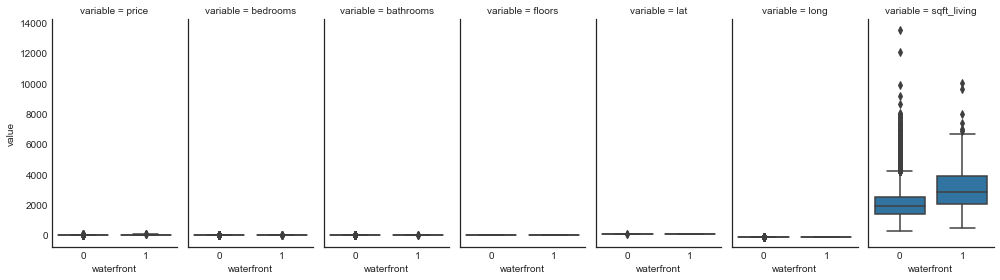

           bathrooms                                                   \
               count      mean       std   min  25%   50%   75%   max   
waterfront                                                              
0            21450.0  2.110478  0.765648  0.00  1.5  2.25  2.50  8.00   
1              163.0  2.677914  1.092456  0.75  2.0  2.50  3.25  6.75   

           bedrooms             ...        price         sqft_living  \
              count      mean   ...          75%     max       count   
waterfront                      ...                                    
0           21450.0  3.371375   ...      6.39897  77.000     21450.0   
1             163.0  3.300613   ...     22.15000  70.625       163.0   

                                                                              
                   mean          std    min     25%     50%     75%      max  
waterfront                                                                    
0           2071.587972   906.257233

In [4]:
# We only have one categorical variable, and that is waterfront. We will make a boxplot for each continuous variable.

# Restructure the data so we can use FacetGrid rather than making a boxplot
# for each variable separately.
df_long = df_explore
df_long = pd.melt(df_long, id_vars=['waterfront'])

g = sns.FacetGrid(df_long, col="variable", size=4, aspect=.5)
g = g.map(sns.boxplot, "waterfront", "value")
plt.show()

# Descriptive statistics by group.
print(df_explore.groupby('waterfront').describe())

# Test whether group differences are significant.
for col in df_explore.loc[:,'price':'sqft_living'].columns:
    print(col)
    print(stats.ttest_ind(
        df_explore[df_explore['waterfront'] == 0][col].dropna(),
        df_explore[df_explore['waterfront'] == 1][col].dropna()
    ))

I will come back to the box plot scaling issue. Is there a way to give each their own y-axis? Or do I need to normalize before I can explore my data?

The t-tests still work! It appears that the effect of waterfront has statistically insignificant effect on the number of bathrooms in a house. I find this a little peculiar, since the number of rooms in a house is different for waterfront vs non-waterfront homes. Shouldn't there be more or less bathrooms if there are more or less bedrooms?

# Let's Make Some Features!

In [28]:
# First feature: I think we can round up the number of bathrooms in a house, 
# and the new feaure will be the number of toilets.
df_features = pd.DataFrame()
df_features['toilets'] = df_explore.bathrooms.apply(lambda x: ceil(x))

# Second feature: let's take the square root of the square footage. We will quasi-assume each property is
# square, and this feature will give us side length
df_features['side_length'] = df_explore.sqft_living.apply(lambda x: x**(0.5))

# Third feature: Square footage per bathroom. Why not?
df_features['sqft_bath'] = df_explore.sqft_living.div(df_explore.bathrooms)

# Fourth feature: Similar to above, let's make a square footage per bedroom as well
df_features['sqft_bed'] = df_explore.sqft_living.div(df_explore.bedrooms)

# Fifth feature: If we add up the bathrooms, bedrooms, and add 2 for a living room and kitchen,
# we would have the total_rooms
df_features['total_rooms'] = df_explore.bedrooms.add(df_explore.bathrooms) + 2

# Sixth feature: The distance to geographic center of Seattle can be approximated
# by treating the lat and long coordinates as cartesian coordinates, since this data
# is over a relatively small distance. 
lat_center = 47.6223
lon_center = -122.3522
df_features['from_center'] = np.sqrt((df_explore.lat - lat_center)**2 + 
                                     (df_explore.long - lon_center)**2)


# Seventh feature:


# Eighth feature:

# Ninth feature:

# Tenth feature:

df_features.head(n=7)

,toilets,side_length,sqft_bath,sqft_bed,total_rooms,from_center
0,1,34.351128,1180.000000,393.333333,6.00,0.146309
1,3,50.695167,1142.222222,856.666667,7.25,0.104134
2,1,27.748874,770.000000,385.000000,5.00,0.166048
3,3,44.271887,653.333333,490.000000,9.00,0.109393
4,2,40.987803,840.000000,560.000000,7.00,0.307249
5,5,73.620649,1204.444444,1355.000000,10.50,0.348841
6,3,41.412558,762.222222,571.666667,7.25,0.313614


In [27]:
lat1 = math.radians(47.6223)
lon1 = math.radians(122.3522)
lat2 = math.radians(47.4)
lon2 = math.radians(122.4)
d = np.cos(lat1-lat2)*69.172
# d2 = l
# d=2*np.arcsin(np.sqrt((np.sin((lat1-lat2)/2))**2 + 
#                       np.cos(lat1)*np.cos(lat2)*(np.sin((lon1-lon2)/2))**2))
# d2 = np.arccos(np.sin(lat1)*np.sin(lat2)+np.cos(lat1)*np.cos(lat2)*np.cos(lon1-lon2))
print(d, 'd\n', d2, 'd2\n')
lat1

69.1714793649 d
 0.00392057411065 d2



0.8311659323724957

In [6]:
df_explore.head()

,waterfront,price,bedrooms,bathrooms,floors,lat,long,sqft_living
0,0,2.219,3,1.00,1.0,47.5112,-122.257,1180
1,0,5.380,3,2.25,2.0,47.7210,-122.319,2570
2,0,1.800,2,1.00,1.0,47.7379,-122.233,770
3,0,6.040,4,3.00,1.0,47.5208,-122.393,1960
4,0,5.100,3,2.00,1.0,47.6168,-122.045,1680


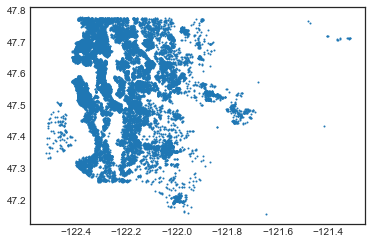

-122.21389640494083 47.56005251931704


In [8]:
# Let's look at all the datapoints we have on a map.
# I did this on a previous assignment, and I think its kind of cool to see so I'll do it again
plt.scatter(df.long, df.lat, s=1)
plt.show()
print(df.long.mean(), df.lat.mean())